In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# System libraries
from pathlib import Path
import os.path
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import time

from PIL import Image
from random import randint

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools



from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow

from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101 # ResNet 101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3


import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

Num GPUs Available:  1


In [2]:
!wget https://www.dropbox.com/s/pok37oacd6xsa07/AD_dataset.zip?dl=0

--2023-06-19 09:27:17--  https://www.dropbox.com/s/pok37oacd6xsa07/AD_dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/pok37oacd6xsa07/AD_dataset.zip [following]
--2023-06-19 09:27:18--  https://www.dropbox.com/s/raw/pok37oacd6xsa07/AD_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca9f88bf7590ff06475832fd523.dl.dropboxusercontent.com/cd/0/inline/B-QlcWBd23pE2t9TP3l7vPeYPEV9TncyVysZa3OGYtS33V-Wyi0uHhdby4jQM0FAF7bHxKdoRKbEMe8xUK5hOwqyU-bxiez_Lr8dA5vLjKtvEMq2uiASZcwN2QoUYhgEfXrda199PRm5RvUIvlaY6jhybtbJNQeePfr1b543jMsDhQ/file# [following]
--2023-06-19 09:27:19--  https://uca9f88bf7590ff06475832fd523.dl.dropboxusercontent.com/cd/0/inline/B-QlcWBd23pE2t9TP3l7vPeYPEV9TncyVysZa3OGYtS33V-Wyi0uHhdby4jQM0FAF7

In [3]:
!unzip /content/AD_dataset.zip?dl=0

Streaming output truncated to the last 5000 lines.
  inflating: OriginalDataset/NonDemented/31 (10).jpg  
  inflating: OriginalDataset/NonDemented/31 (100).jpg  
  inflating: OriginalDataset/NonDemented/31 (11).jpg  
  inflating: OriginalDataset/NonDemented/31 (12).jpg  
  inflating: OriginalDataset/NonDemented/31 (13).jpg  
  inflating: OriginalDataset/NonDemented/31 (14).jpg  
  inflating: OriginalDataset/NonDemented/31 (15).jpg  
  inflating: OriginalDataset/NonDemented/31 (16).jpg  
  inflating: OriginalDataset/NonDemented/31 (17).jpg  
  inflating: OriginalDataset/NonDemented/31 (18).jpg  
  inflating: OriginalDataset/NonDemented/31 (19).jpg  
  inflating: OriginalDataset/NonDemented/31 (2).jpg  
  inflating: OriginalDataset/NonDemented/31 (20).jpg  
  inflating: OriginalDataset/NonDemented/31 (21).jpg  
  inflating: OriginalDataset/NonDemented/31 (22).jpg  
  inflating: OriginalDataset/NonDemented/31 (23).jpg  
  inflating: OriginalDataset/NonDemented/31 (24).jpg  
  inflating: O

In [4]:
#AUGMENTED DATA
aug_data = "/content/AugmentedAlzheimerDataset"
org_data = "/content/OriginalDataset"


In [5]:
ROOT_DIR = "/content/AugmentedAlzheimerDataset"
no_of_images = {}

for dir in os.listdir(ROOT_DIR):
  no_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))


In [6]:
from numpy.random.mtrand import f
def dataFolder(p,split):

# we will create a training folder

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

  for dir in os.listdir(ROOT_DIR):
   os.makedirs("./"+p+"/"+dir)

   for img in np.random.choice ( a = os.listdir(os.path.join(ROOT_DIR,dir)),
                               size= (math.floor(split*no_of_images[dir])-2),
                                replace= False ):

     O= os.path.join(ROOT_DIR,dir,img) #path
     D= os.path.join("./"+p,dir)
     shutil.copy(O,D)
     os.remove(O)

  else:
   print( f" {p} Folder exists ")



In [7]:
image_dir = Path(aug_data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'\\*.JPG')) + list(image_dir.glob(r'\\*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [8]:
def get_dataset(augmented = 0):
    if(augmented == 0):
        image_dir = Path(org_data)
    else:
        image_dir = Path(aug_data)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'\\*.JPG')) + list(image_dir.glob(r'\\*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df


In [9]:
train_df = "/content/AugmentedAlzheimerDataset"
test_df = "/content/OriginalDataset"

In [10]:
len(train_df)

34

In [11]:
train_df = get_dataset(1)
test_df = get_dataset(0)

In [12]:
pd.set_option('display.max_colwidth', None)
train_df.head()

,Filepath,Label


In [13]:
test_df.tail()

,Filepath,Label


In [14]:
print("Train data set label distribution:\n",train_df.Label.value_counts())

print("\nTest data set label distribution:\n", test_df.Label.value_counts())

Train data set label distribution:
 Series([], Name: Label, dtype: int64)

Test data set label distribution:
 Series([], Name: Label, dtype: int64)


In [15]:
base_dir = "/content/AugmentedAlzheimerDataset"
root_dir = ".\\"
train_dir = "/content/AugmentedAlzheimerDataset"
test_dir ="/content/OriginalDataset"
#work_dir = root_dir + "dataset/"

#if os.path.exists(work_dir):
#    remove_tree(work_dir)


#os.mkdir(work_dir)
#copy_tree(train_dir, work_dir)
#copy_tree(test_dir, work_dir)
#print("Working Directory Contents:", os.listdir(work_dir))

In [16]:
#WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [24]:
datagen = IDG(rescale = 1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True)

validation_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=True)

test_gen = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=6400,
                                             class_mode='categorical')

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [25]:
test_gen_plot = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical')

Found 6400 images belonging to 4 classes.


In [19]:
def plot_training_metrics(train_hist, model, test_gen_plot, y_actual, y_pred, classes, model_name):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """

    # Evaluate the results:
    #. test_metrics[0] = loss,
    #  test_metrics[1] = auc,
    #  test_metrics[2] = acc
    # Evaluate the results:
    test_metrics = model.evaluate(test_gen_plot, verbose = False)
    AUC       = test_metrics[1]*100
    Acc       = test_metrics[2]*100
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))


    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)

    # create plots
    plt.subplots(figsize=(12,4))

    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[AUC/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()


     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

In [20]:
def prepare_for_test(model, test_gen):
    data, y_true = test_gen.next()
    y_pred_ = model.predict(data, batch_size = 64)
    y_pred = []
    for i in range(y_pred_.shape[0]):
        y_pred.append(np.argmax(y_pred_[i]))

    y_true = np.argmax(y_true, axis=1)

    return y_true, y_pred

In [ ]:
vgg = VGG19(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 88, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 88, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 88, 128)       147584    
                                                              

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=15, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/15
77/77 [==============================] - 893s 12s/step - loss: 1.0435 - auc: 0.8156 - acc: 0.5701 - val_loss: 0.7686 - val_auc: 0.9156 - val_acc: 0.7137
Epoch 2/15
77/77 [==============================] - 889s 12s/step - loss: 0.7163 - auc: 0.9233 - acc: 0.7269 - val_loss: 0.6748 - val_auc: 0.9279 - val_acc: 0.7287
Epoch 3/15
77/77 [==============================] - 891s 12s/step - loss: 0.6201 - auc: 0.9427 - acc: 0.7643 - val_loss: 0.6630 - val_auc: 0.9253 - val_acc: 0.7360
Epoch 4/15
77/77 [==============================] - 891s 12s/step - loss: 0.5581 - auc: 0.9542 - acc: 0.7928 - val_loss: 0.5536 - val_auc: 0.9508 - val_acc: 0.7743
Epoch 5/15
77/77 [==============================] - 893s 12s/step - loss: 0.5138 - auc: 0.9619 - acc: 0.8104 - val_loss: 0.5092 - val_auc: 0.9609 - val_acc: 0.8125
Epoch 6/15
77/77 [==============================] - 890s 12s/step - loss: 0.4802 - auc: 0.9673 - acc: 0.8285 - val_loss: 0.4862 - val_auc: 0.9637 - val_acc: 0.8161
Epoch 7/15
77/77

100/100 [==============================] - 169s 2s/step

 Model AUC 98.36%, Accuracy 88.23% on Test Data

              precision    recall  f1-score   support

        mild       0.88      0.93      0.90       896
    moderate       0.97      1.00      0.98        64
      normal       0.92      0.87      0.89      3200
   very-mild       0.83      0.88      0.86      2240

    accuracy                           0.88      6400
   macro avg       0.90      0.92      0.91      6400
weighted avg       0.88      0.88      0.88      6400



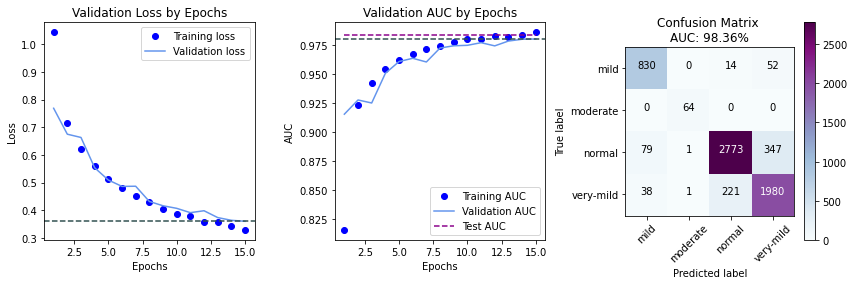

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "vgg19")

In [ ]:
# SAVE MODEL
model_dir = ".\\alzheimer_vgg19_model"
model.save(model_dir, save_format='h5')
np.save('my_vgg19_history.npy', history.history)
#history=np.load('my_vgg19_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

In [ ]:
vgg = VGG16(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 88, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 88, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 88, 128)       147584    
                                                              

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)
tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=15, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/15
77/77 [==============================] - 716s 9s/step - loss: 1.0424 - auc: 0.8183 - acc: 0.5791 - val_loss: 0.7416 - val_auc: 0.9232 - val_acc: 0.7275
Epoch 2/15
77/77 [==============================] - 721s 9s/step - loss: 0.6723 - auc: 0.9353 - acc: 0.7513 - val_loss: 0.6247 - val_auc: 0.9392 - val_acc: 0.7481
Epoch 3/15
77/77 [==============================] - 719s 9s/step - loss: 0.5653 - auc: 0.9549 - acc: 0.7929 - val_loss: 0.5346 - val_auc: 0.9595 - val_acc: 0.8067
Epoch 4/15
77/77 [==============================] - 721s 9s/step - loss: 0.5000 - auc: 0.9655 - acc: 0.8191 - val_loss: 0.4802 - val_auc: 0.9678 - val_acc: 0.8237
Epoch 5/15
77/77 [==============================] - 725s 9s/step - loss: 0.4552 - auc: 0.9719 - acc: 0.8376 - val_loss: 0.4511 - val_auc: 0.9710 - val_acc: 0.8320
Epoch 6/15
77/77 [==============================] - 710s 9s/step - loss: 0.4290 - auc: 0.9744 - acc: 0.8476 - val_loss: 0.4249 - val_auc: 0.9744 - val_acc: 0.8452
Epoch 7/15
77/77 [====

100/100 [==============================] - 139s 1s/step

 Model AUC 98.72%, Accuracy 89.36% on Test Data

              precision    recall  f1-score   support

        mild       0.81      0.97      0.88       896
    moderate       1.00      1.00      1.00        64
      normal       0.94      0.87      0.91      3200
   very-mild       0.86      0.89      0.88      2240

    accuracy                           0.89      6400
   macro avg       0.90      0.93      0.92      6400
weighted avg       0.90      0.89      0.89      6400



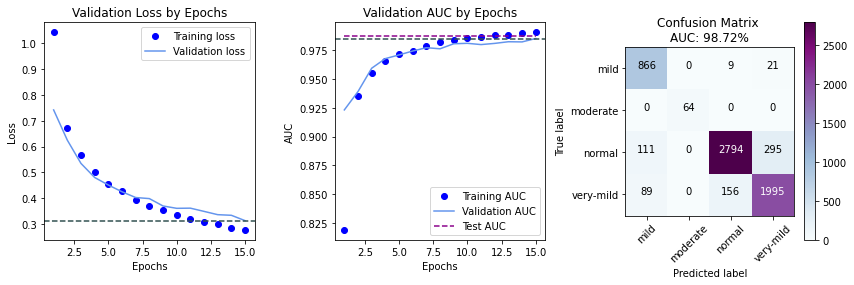

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "vgg16")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_vgg16_model"
model.save(model_dir, save_format='h5')
np.save('my_vgg16_history.npy', history.history)
#history=np.load('my_vgg16_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

In [ ]:
#inceptionv3 model
model = InceptionV3(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 87, 87, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 87, 87, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)
tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=15, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/15
77/77 [==============================] - 165s 2s/step - loss: 2.9034 - auc: 0.7584 - acc: 0.5327 - val_loss: 0.7835 - val_auc: 0.9002 - val_acc: 0.6692
Epoch 2/15
77/77 [==============================] - 154s 2s/step - loss: 0.6901 - auc: 0.9166 - acc: 0.7031 - val_loss: 0.7529 - val_auc: 0.9107 - val_acc: 0.6913
Epoch 3/15
77/77 [==============================] - 154s 2s/step - loss: 0.6026 - auc: 0.9360 - acc: 0.7480 - val_loss: 0.6340 - val_auc: 0.9332 - val_acc: 0.7387
Epoch 4/15
77/77 [==============================] - 154s 2s/step - loss: 0.6066 - auc: 0.9381 - acc: 0.7564 - val_loss: 0.5293 - val_auc: 0.9511 - val_acc: 0.7855
Epoch 5/15
77/77 [==============================] - 153s 2s/step - loss: 0.4695 - auc: 0.9606 - acc: 0.8079 - val_loss: 0.4878 - val_auc: 0.9579 - val_acc: 0.8008
Epoch 6/15
77/77 [==============================] - 152s 2s/step - loss: 0.4016 - auc: 0.9712 - acc: 0.8381 - val_loss: 0.4353 - val_auc: 0.9663 - val_acc: 0.8240
Epoch 7/15
77/77 [====

100/100 [==============================] - 31s 291ms/step

 Model AUC 96.49%, Accuracy 81.30% on Test Data

              precision    recall  f1-score   support

        mild       0.54      1.00      0.70       896
    moderate       0.97      1.00      0.98        64
      normal       0.91      0.85      0.88      3200
   very-mild       0.91      0.69      0.78      2240

    accuracy                           0.81      6400
   macro avg       0.83      0.88      0.84      6400
weighted avg       0.86      0.81      0.82      6400



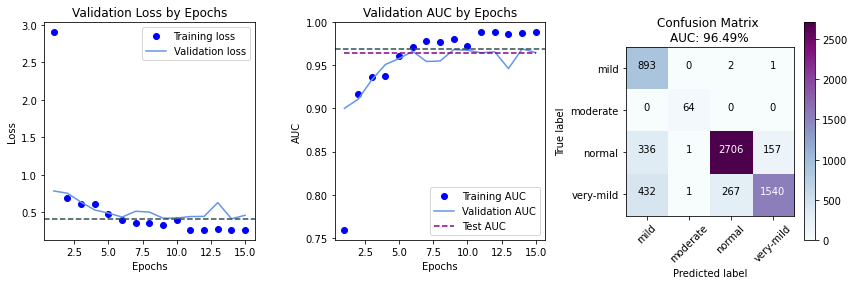

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "inceptionv3")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_inceptionv3_model"
model.save(model_dir, save_format='h5')
np.save('my_inceptionv3_history.npy', history.history)
#history=np.load('my_inceptionv3_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

In [ ]:
model = Xception(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)
model.summary()



83683744/83683744 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 87, 87, 32)   864         ['input_4[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 87, 87, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                           

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=15, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/15
77/77 [==============================] - 397s 5s/step - loss: 2.0457 - auc: 0.7664 - acc: 0.5433 - val_loss: 0.6947 - val_auc: 0.9136 - val_acc: 0.6989
Epoch 2/15
77/77 [==============================] - 395s 5s/step - loss: 0.6464 - auc: 0.9257 - acc: 0.7198 - val_loss: 0.6263 - val_auc: 0.9308 - val_acc: 0.7369
Epoch 3/15
77/77 [==============================] - 398s 5s/step - loss: 0.5511 - auc: 0.9475 - acc: 0.7698 - val_loss: 0.5807 - val_auc: 0.9396 - val_acc: 0.7528
Epoch 4/15
77/77 [==============================] - 395s 5s/step - loss: 0.4939 - auc: 0.9587 - acc: 0.8007 - val_loss: 0.5261 - val_auc: 0.9517 - val_acc: 0.7819
Epoch 5/15
77/77 [==============================] - 395s 5s/step - loss: 0.4615 - auc: 0.9633 - acc: 0.8121 - val_loss: 0.6032 - val_auc: 0.9375 - val_acc: 0.7554
Epoch 6/15
77/77 [==============================] - 394s 5s/step - loss: 0.4641 - auc: 0.9615 - acc: 0.8061 - val_loss: 0.4707 - val_auc: 0.9612 - val_acc: 0.8217
Epoch 7/15
77/77 [====

100/100 [==============================] - 63s 616ms/step

 Model AUC 98.57%, Accuracy 88.53% on Test Data

              precision    recall  f1-score   support

        mild       0.96      0.79      0.87       896
    moderate       1.00      1.00      1.00        64
      normal       0.87      0.94      0.90      3200
   very-mild       0.88      0.84      0.86      2240

    accuracy                           0.89      6400
   macro avg       0.93      0.89      0.91      6400
weighted avg       0.89      0.89      0.88      6400



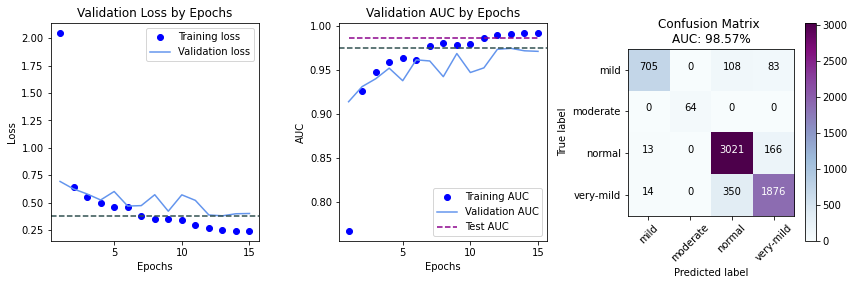

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "xception")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_xception_model"
#model.save(model_dir, save_format='h5')
#np.save('my_xception_history.npy', history.history)
#history=np.load('my_xception_history.npy',allow_pickle='TRUE').item()
#premodel = tensorflow.keras.models.load_model(model_dir)

In [ ]:
model = MobileNetV2(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 88, 88, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 88, 88, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)             

In [ ]:
#mobilenetv2_model
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=15, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/15
77/77 [==============================] - 1181s 15s/step - loss: 1.9610 - auc: 0.8221 - acc: 0.6119 - val_loss: 0.5903 - val_auc: 0.9373 - val_acc: 0.7437
Epoch 2/15
77/77 [==============================] - 1177s 15s/step - loss: 0.4514 - auc: 0.9636 - acc: 0.8150 - val_loss: 0.4076 - val_auc: 0.9708 - val_acc: 0.8390
Epoch 3/15
77/77 [==============================] - 1156s 15s/step - loss: 0.3621 - auc: 0.9765 - acc: 0.8570 - val_loss: 0.3889 - val_auc: 0.9728 - val_acc: 0.8464
Epoch 4/15
77/77 [==============================] - 1150s 15s/step - loss: 0.2491 - auc: 0.9899 - acc: 0.9095 - val_loss: 0.3463 - val_auc: 0.9783 - val_acc: 0.8629
Epoch 5/15
77/77 [==============================] - 1169s 15s/step - loss: 0.2051 - auc: 0.9936 - acc: 0.9296 - val_loss: 0.3935 - val_auc: 0.9727 - val_acc: 0.8396
Epoch 6/15
77/77 [==============================] - 1169s 15s/step - loss: 0.1656 - auc: 0.9963 - acc: 0.9492 - val_loss: 0.2967 - val_auc: 0.9836 - val_acc: 0.8855
Epoch 7/15

100/100 [==============================] - 187s 2s/step

 Model AUC 98.68%, Accuracy 90.16% on Test Data

              precision    recall  f1-score   support

        mild       0.85      0.94      0.89       896
    moderate       1.00      0.95      0.98        64
      normal       0.91      0.92      0.92      3200
   very-mild       0.91      0.85      0.88      2240

    accuracy                           0.90      6400
   macro avg       0.92      0.92      0.92      6400
weighted avg       0.90      0.90      0.90      6400



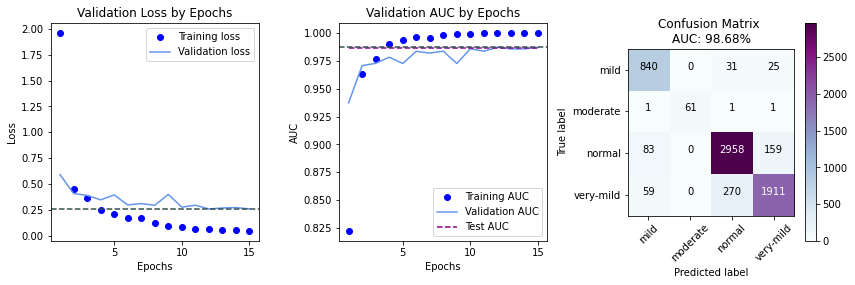

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "mobilenetv2")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_mobilenetv2_model"
model.save(model_dir, save_format='h5')
np.save('my_mobilenetv2_history.npy', history.history)
#history=np.load('my_mobilenetv2_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

In [27]:
model = DenseNet169(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.summary()


51877672/51877672 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 182, 182, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 88, 88, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization

In [29]:

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=15, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/15
77/77 [==============================] - 66s 721ms/step - loss: 3.0314 - auc: 0.7404 - acc: 0.5322 - val_loss: 0.7198 - val_auc: 0.9133 - val_acc: 0.7098
Epoch 2/15
77/77 [==============================] - 51s 664ms/step - loss: 0.5964 - auc: 0.9371 - acc: 0.7468 - val_loss: 0.5104 - val_auc: 0.9559 - val_acc: 0.7984
Epoch 3/15
77/77 [==============================] - 51s 666ms/step - loss: 0.4974 - auc: 0.9570 - acc: 0.7953 - val_loss: 0.4609 - val_auc: 0.9635 - val_acc: 0.8167
Epoch 4/15
77/77 [==============================] - 52s 671ms/step - loss: 0.4133 - auc: 0.9717 - acc: 0.8388 - val_loss: 0.4330 - val_auc: 0.9676 - val_acc: 0.8246
Epoch 5/15
77/77 [==============================] - 52s 669ms/step - loss: 0.3704 - auc: 0.9778 - acc: 0.8602 - val_loss: 0.4297 - val_auc: 0.9675 - val_acc: 0.8228
Epoch 6/15
77/77 [==============================] - 52s 669ms/step - loss: 0.3418 - auc: 0.9809 - acc: 0.8708 - val_loss: 0.3673 - val_auc: 0.9769 - val_acc: 0.8599
Epoch 7/15

100/100 [==============================] - 5s 27ms/step

 Model AUC 97.97%, Accuracy 86.20% on Test Data

              precision    recall  f1-score   support

        mild       0.75      0.98      0.85       896
    moderate       1.00      1.00      1.00        64
      normal       0.85      0.96      0.90      3200
   very-mild       0.97      0.67      0.80      2240

    accuracy                           0.86      6400
   macro avg       0.89      0.90      0.89      6400
weighted avg       0.88      0.86      0.86      6400



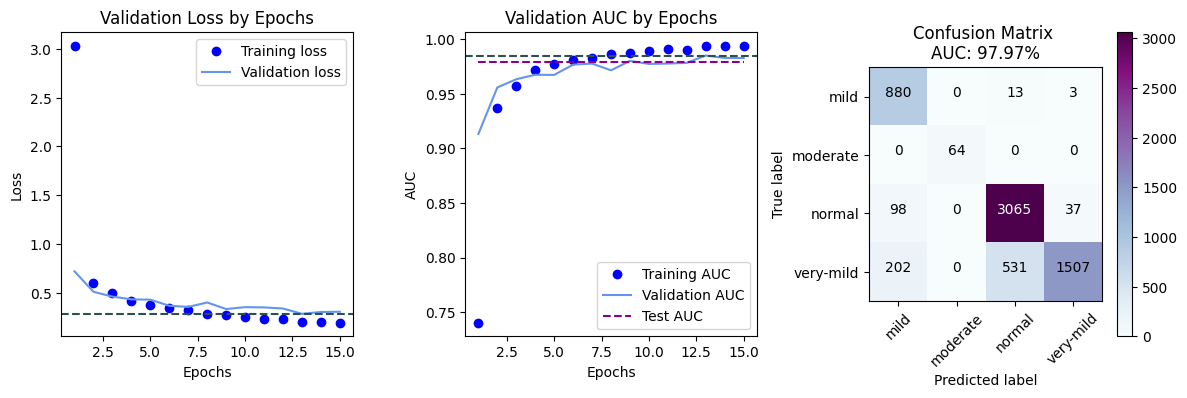

In [30]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "densenet169")

In [31]:
# SAVE MODEL
model_dir = "./alzheimer_densenet169_model"
model.save(model_dir, save_format='h5')
np.save('my_densenet169_history.npy', history.history)
#history=np.load('my_densenet169_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

In [32]:
model = DenseNet121(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)
model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 182, 182, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 88, 88, 64)   9408        ['zero_padding2d_2[0][0]']       
                           

In [34]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=25, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/25
77/77 [==============================] - 60s 695ms/step - loss: 3.7627 - auc: 0.6930 - acc: 0.4738 - val_loss: 0.7265 - val_auc: 0.9063 - val_acc: 0.6913
Epoch 2/25
77/77 [==============================] - 51s 663ms/step - loss: 0.6360 - auc: 0.9284 - acc: 0.7279 - val_loss: 0.5734 - val_auc: 0.9436 - val_acc: 0.7705
Epoch 3/25
77/77 [==============================] - 51s 666ms/step - loss: 0.5395 - auc: 0.9498 - acc: 0.7765 - val_loss: 0.5085 - val_auc: 0.9558 - val_acc: 0.7972
Epoch 4/25
77/77 [==============================] - 51s 667ms/step - loss: 0.4782 - auc: 0.9610 - acc: 0.8062 - val_loss: 0.4693 - val_auc: 0.9617 - val_acc: 0.8114
Epoch 5/25
77/77 [==============================] - 51s 665ms/step - loss: 0.4360 - auc: 0.9674 - acc: 0.8270 - val_loss: 0.4133 - val_auc: 0.9714 - val_acc: 0.8387
Epoch 6/25
77/77 [==============================] - 51s 666ms/step - loss: 0.4112 - auc: 0.9707 - acc: 0.8344 - val_loss: 0.5475 - val_auc: 0.9462 - val_acc: 0.7631
Epoch 7/25

100/100 [==============================] - 4s 23ms/step

 Model AUC 99.31%, Accuracy 92.44% on Test Data

              precision    recall  f1-score   support

        mild       0.92      0.95      0.94       896
    moderate       1.00      1.00      1.00        64
      normal       0.93      0.94      0.93      3200
   very-mild       0.91      0.89      0.90      2240

    accuracy                           0.92      6400
   macro avg       0.94      0.94      0.94      6400
weighted avg       0.92      0.92      0.92      6400



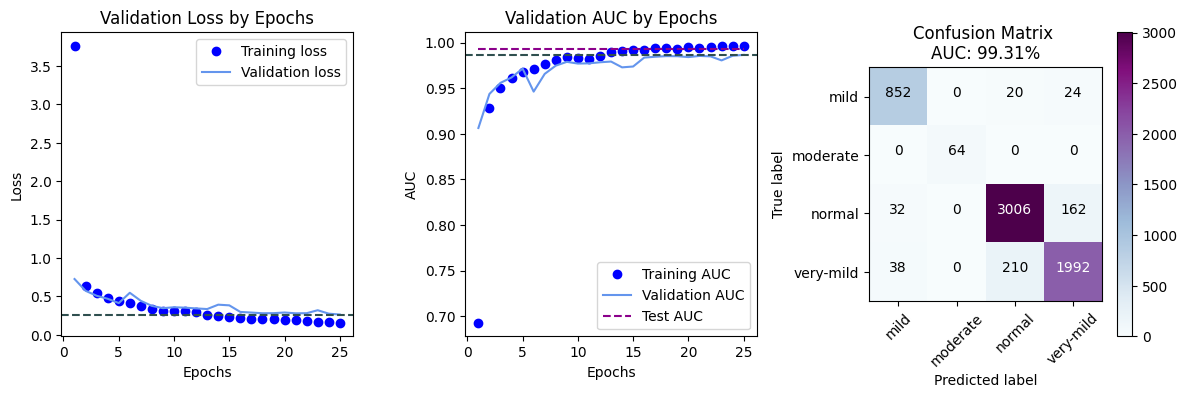

In [35]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "densenet121")

In [36]:
# SAVE MODEL
model_dir = "./alzheimer_densenet121_model"
model.save(model_dir, save_format='h5')
np.save('my_densenet121_history.npy', history.history)
#history=np.load('my_densenet121_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)